In [10]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Grayscale

import os
import torch.optim as optim
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from networks import *
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from PIL import Image

# Set hyperparams

In [33]:
epochs = 10
lr = 0.001
batch_size = 32

# Fix data

3598
torch.Size([3, 32, 32])
Label:  0 Black Sea Sprat


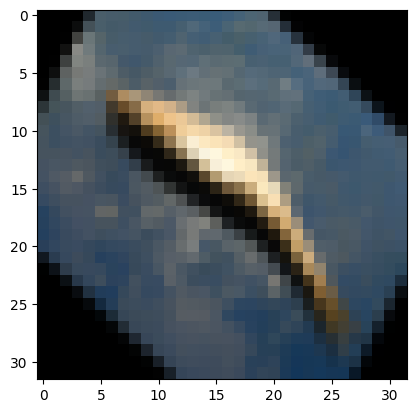

In [106]:
classes = {
  0: "Black Sea Sprat",
  1: "Hourse Mackerel",
  2: "Red Sea Bream",
  3: "Shrimp"
}

def load_data():
    transform = Compose([ Resize((32, 32)), ToTensor(), transforms.Normalize([0.,], [1.])]) #Grayscale(1), 
    dataset = ImageFolder('C:/Users/ingvilrh/OneDrive - NTNU/Masteroppgave23/full_fishdata', transform=transform)
    return dataset

def split_dataset(dataset):
    train_size = int(0.7 * len(dataset))
    val_size = test_size = (len(dataset) - train_size) // 2
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

def check_classes(dataset):
    print("Your classes are: ", dataset.classes)

def get_datasize(dataset):
    image, label = dataset[0]
    print(image.size())

def show_image(dataset, idx):
    image, label = dataset[idx]
    plt.imshow(image.permute(1,2,0), cmap='gray')
    print("Label: ", label, classes[label])

data = load_data()
print(len(data))
get_datasize(data)
show_image(data, 800)

train_dataset, val_dataset, test_dataset = split_dataset(data)


# Make dataloaders

In [163]:
def make_dataloaders(train_dataset, val_dataset, test_dataset):
    train_dataloader = DataLoader(train_dataset, batch_size)
    val_dataloader = DataLoader(train_dataset, batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)
    return train_dataloader, val_dataloader, test_dataloader

train_data, val_data, test_data = split_dataset(data)
train_loader, val_loader, test_loader = make_dataloaders(train_data, val_data, test_data)
print("Your dataset has a length of:", len(data))
print("Your training set has a length of:", len(train_data))
print("Your test set has a length of:", len(test_data))
print("Your val set has a length of:", len(val_data))




Your dataset has a length of: 3598
Your training set has a length of: 2518
Your test set has a length of: 540
Your val set has a length of: 540


# Create NN

In [164]:
from networks import * 
from torch import optim
model = Net0()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  

# Define functions for training

In [138]:
#iterate over the training dataset and try to converge to optimal parameters
def train_loop(dataloader, model, loss_fn, optimizer, epoch_loss, loss_vals):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        

        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    return loss_vals
#iterate over the test dataset to check if model performance is improving
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train the model

In [167]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loss_vals = []
for t in range(epochs):
    epoch_loss = []
    print(f"Epoch {t+1}\n-------------------------------")
    loss_vals = train_loop(train_loader, model, loss_fn, optimizer, epoch_loss, loss_vals)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.323701  [   32/ 2518]
Test Error: 
 Accuracy: 27.6%, Avg loss: 2.281138 

Epoch 2
-------------------------------
loss: 2.299795  [   32/ 2518]
Test Error: 
 Accuracy: 27.6%, Avg loss: 2.261128 

Epoch 3
-------------------------------
loss: 2.278888  [   32/ 2518]
Test Error: 
 Accuracy: 27.6%, Avg loss: 2.242556 

Epoch 4
-------------------------------
loss: 2.259963  [   32/ 2518]
Test Error: 
 Accuracy: 27.6%, Avg loss: 2.224552 

Epoch 5
-------------------------------
loss: 2.241806  [   32/ 2518]
Test Error: 
 Accuracy: 28.0%, Avg loss: 2.206507 

Epoch 6
-------------------------------
loss: 2.223550  [   32/ 2518]
Test Error: 
 Accuracy: 28.5%, Avg loss: 2.187771 

Epoch 7
-------------------------------
loss: 2.204728  [   32/ 2518]
Test Error: 
 Accuracy: 28.9%, Avg loss: 2.168301 

Epoch 8
-------------------------------
loss: 2.184943  [   32/ 2518]
Test Error: 
 Accuracy: 28.1%, Avg loss: 2.146735 

Epoch 9
----------------

# Evaluate the model

In [168]:
import torchvision

def evaluate_accuracy(test_loader, model):
    correct = 0
    total = 0

    dataloader = test_loader
    with torch.no_grad():
            for data in dataloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

evaluate_accuracy(test_loader, model)
            

Accuracy of the network on the 10000 test images: 20 %


In [ ]:
#show_image(test_data, 0)
#image, label = test_data[0]

def test_single_image(test_loader, model, idx):
    with torch.no_grad():
        data1 = next(iter(test_loader))  # get the first data item from the dataloader
        data2 = next(iter(test_loader)) #theese batches produces same output, check it out!!!!! Det har noe med shuffle å gjøre!

        images, labels = data1

        #Get a image for testing, choosing the first one
        first_image = images[idx]
        first_label = labels[idx]

        #Show first image
        plt.imshow(first_image.permute(1,2,0), cmap='gray')

        #Printing the real class
        print("The image truly belongs to class: ", first_label.item(), classes[first_label.item()])

        #Get predictions as a list for all the images in the dataloader
        outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    #Print the predicted classes for the batch we predicted
    print(predicted)
    print(labels)

    #Print the predicted class for the image we showed
    print("The image was predicted to belong to class: ", predicted[idx].item(), classes[predicted[idx].item()])
    
test_single_image(test_loader, model, 30)


In [170]:
def classes_hit(test_loader, model, num_classes):
    with torch.no_grad():
        data1 = next(iter(test_loader))  # get the first data item from the dataloader
        data2 = next(iter(test_loader))
        data3 = next(iter(test_loader))
        data4 = next(iter(test_loader))

        images, labels = data3

        #Get predictions as a list for all the images in the dataloader
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

    #Print the predicted classes for the batch we predicted
    print("Predictd classes")
    print(predicted)
    print("Coreect labels: ")
    print(labels)

    correct = {
        0 : 0,
        1 : 0,
        2 : 0,
        3 : 0
    }

    miss = {
        0 : 0,
        1 : 0,
        2 : 0,
        3 : 0
    }

    for i in range(len(predicted)):
        if predicted[i] == labels[i]:
            correct[predicted[i].item()] += 1
        else:
            miss[predicted[i].item()] += 1
    
    #Print it pretty
    for c in range(num_classes):
        print(classes[c], "got", correct[c], "correct predictions")

classes_hit(test_loader, model, 4)

Predictd classes
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Coreect labels: 
tensor([1, 3, 3, 3, 3, 2, 0, 3, 2, 2, 2, 0, 0, 1, 3, 2, 0, 2, 0, 1, 3, 3, 2, 2,
        1, 1, 3, 0, 2, 0, 3, 1])
Black Sea Sprat got 7 correct predictions
Hourse Mackerel got 0 correct predictions
Red Sea Bream got 0 correct predictions
Shrimp got 0 correct predictions


# Plot loss

Text(0, 0.5, 'loss')

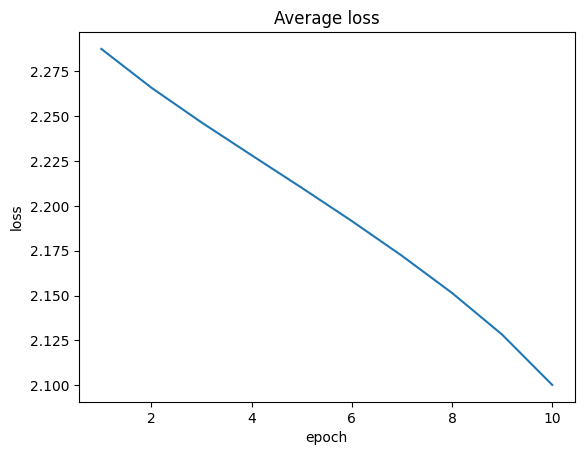

In [176]:
plt.plot([1,2,3,4,5,6,7,8,9,10], loss_vals)
plt.title('Average loss')
plt.xlabel('epoch')
plt.ylabel('loss')